**Import the important modules**

In [2]:
import pandas as pd # for Dataframe.
import numpy as np # for array formation.
import pickle
import datetime # for datetime.
import string
import random as ran # for randomization
from random import randint
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg
import re # for regular expression
import nltk # for natural language processing
import tensorflow as tf # for tensorflow
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.utils import shuffle #for randomization in data. 
from sklearn.model_selection import train_test_split #split the data 
from tensorflow.keras.applications.xception import Xception ,preprocess_input # use pre-trained xception model for image feature extraction.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer# for tokenization of text data.
from tensorflow.keras.preprocessing.sequence import pad_sequences # padding the text tokenize sequence.

**Let's import the data files**

In [4]:

train_input = np.load("/content/train_input.npy",allow_pickle=True)
train_output = np.load("/content/train_output.npy",allow_pickle=True)

validation_input = np.load("/content/validation_input.npy",allow_pickle=True)
validation_output = np.load("/content/validation_output.npy",allow_pickle=True)

test_input = np.load("/content/test_input.npy",allow_pickle=True)
test_output = np.load("/content/test_output.npy",allow_pickle=True)

**MAKE THE WORD EMBEDDINGS USING FATSTEXT PRE-TRAINED MODELS**

**tokenizer**

In [5]:
token = pickle.load(open("/content/tokenizer.pkl", 'rb'))
embedding_matrix = pickle.load(open("/content/embedding_matrix_oversample.pkl", 'rb'))
path= pickle.load(open("/content/path.pkl", 'rb'))

In [6]:
from google.colab import drive# import the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
maximum_length_output_sentences= 80 

In [8]:
SIZE_OF_BATCH=32 #Batch size
SIZE_OF_BUFFER= 500  #Batch Buffer
DIMENSION_OF_EMBEDDING= 300 #Embedding
UNITS= 300  #units

**Lets get encoder and decoder**

In [9]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Reshape, Concatenate
class encoder(tf.keras.Model):
  """ encoder for image features extracted by pre-trained model"""
  def __init__(self,DIMENSION_OF_EMBEDDING):
    super(encoder,self).__init__()
    self.flat=tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(DIMENSION_OF_EMBEDDING, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),name='output_layer_of_encoder')# dense layer.
    
  def call(self, a):
    concatination_enc= Concatenate()([a[:,0], a[:,1]])# concatenate
    a=self.flat(concatination_enc)
    a =self.dense(a)
    return a

In [10]:
class decoder(tf.keras.Model):
  """ RNN decoder with attention over image features."""
  def __init__(self,  DIMENSION_OF_EMBEDDING, UNITS, size_of_vocabulary):
        super(decoder, self).__init__()
        self.units = UNITS
        self.concat = tf.keras.layers.Concatenate()
        self.embedding = tf.keras.layers.Embedding(size_of_vocabulary,DIMENSION_OF_EMBEDDING,weights=[embedding_matrix], input_length=maximum_length_output_sentences, trainable=False)
        self.lstm = tf.keras.layers.LSTM(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer=tf.keras.initializers.glorot_uniform(seed=45))
        self.dense = tf.keras.layers.Dense(size_of_vocabulary, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45))
        self.attention = tf.keras.layers.AdditiveAttention(self.units)
        self.flatten = tf.keras.layers.Flatten()
  def call(self, a,features,hidden):
        attention_outputs = self.attention([features,hidden]) # attention have the encoder features and the hidden states
        embedding = self.embedding(a)# here we make the embedding of text
        concat_output = self.concat([embedding,tf.expand_dims(attention_outputs,1)])# here we concat the embedding and attention output
        output, prev_state_vector,_ = self.lstm(concat_output)# here we pass the concat output 
        a= self.flatten(output)
        a= self.dense(a)
        return a,prev_state_vector

In [11]:
size_of_vocabulary=1445

In [12]:
Encoder= encoder(DIMENSION_OF_EMBEDDING) # encoder


In [13]:
Decoder= decoder(DIMENSION_OF_EMBEDDING, UNITS, size_of_vocabulary)# decoder

In [14]:
Encoder.built = True
Decoder.built = True

In [15]:
encod_temp = Encoder(np.random.rand(1,30,1024))

In [16]:
decod_temp = Decoder(np.random.rand(1,1),np.random.rand(1,300),np.random.rand(1,300))

In [17]:
Encoder.load_weights('/content/abhi_krishna_oversample_weights_encoder_final_final.h5')

In [18]:
Decoder.load_weights('/content/drive/MyDrive/abhi_krishna_oversample_weights_decoder_final.h5')

In [19]:
# base_model= tf.keras.applications.VGG16(include_top=False,weights ='imagenet')
# model_for_image_features= Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

In [20]:
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.applications import densenet
chex = densenet.DenseNet121(include_top=False, weights = None, input_shape=(299,299,3))
X = chex.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chex.input, outputs=X)
model.load_weights('/content/drive/MyDrive/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
model = Model(inputs = model.input, outputs = model.layers[-2].output)
avg_pooling=tf.keras.layers.GlobalAveragePooling2D(data_format=None)(model.output)
model_for_image_features=Model(inputs=model.input,outputs=avg_pooling)

In [21]:
def tensor_of_image(path_of_image, name_of_image, model):
  """ Here we extract the features of the image"""
  i = tf.io.read_file(path_of_image + str(name_of_image)) # read file
  i = tf.image.decode_jpeg(i, channels=3) # decode the jpeg
  i = tf.image.resize(i, (299,299)) # resize the image
  i = tf.keras.applications.xception.preprocess_input(i) # extract the features with the help of xception model.
  features_of_the_image = model(tf.constant(i)[None, :]) # features of image.
  return features_of_the_image

In [22]:
def score(x):
    """cumulative score of the sentences"""
    return x[1]/len(x[0])

def beam_search(name_of_image, beam_index):
    """take image as input in beam search"""
    hidden_1 =  tf.zeros((1, UNITS))# Initialize the hidden state
    tensor_of_im = tf.convert_to_tensor([tensor_of_image(path_of_image,path[0], model_for_image_features),# img[0],img[1] 
                                      tensor_of_image(path_of_image,path[1],  model_for_image_features)])
    features_of_image = tf.constant(tensor_of_im)[None, :]# get the features of the image
    values_of_features = Encoder(features_of_image)# get the encoder output
    start = [token.word_index["<start>"]] # here we get the start index
    word_decoder = [[start, 0.0]]
    while len(word_decoder[0][0]) < maximum_length_output_sentences:
        temp = []
        for s in word_decoder:
            predict,hidden_1 = Decoder(tf.cast(tf.expand_dims([s[0][-1]], 0), tf.float32), values_of_features, hidden_1) # het the output from the decoder
            word_preds = np.argsort(predict[0])[-beam_index:]# here we return the indices of the predictions
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]# here we get the next impresssiona and probability score
                next_cap.append(w)
                prob += predict[0][w]
                temp.append([next_cap, prob.numpy()])
        word_decoder = temp
        # Sorting according to the probabilities scores
        word_decoder = sorted(word_decoder, reverse=False, key=score)
        # Getting the top words
        word_decoder = word_decoder[-beam_index:]
    word_decoder = word_decoder[-1][0]
    impression = [token.index_word[i] for i in word_decoder if i !=0]
    result = []
    
    for i in impression:
        if i != '<end>':
            result.append(i)
        else:
            break
    text = ' '.join(result[1:])
    return result, text

In [23]:
import matplotlib.image as mpimg
from nltk.translate.bleu_score import sentence_bleu
def test_img_cap_beam(img_data, actual_text, beam_indexing):
    result, text = beam_search(img_data, beam_index = beam_indexing)
    """Displays images for given input array of image names"""
    """ it will display the images for the given array of images names"""
    fig, axs = plt.subplots(1, len(img_data), figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data, axs.flatten()):
        img_=mpimg.imread(path_of_image+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    reference = [actual_text.split()[1:-1]]
    result = result[1:]
    print("Beam Search index is :", beam_indexing)
    print("Actual impression is:", actual_text)
    print("Predicted impression is :",text)
    print('*'*50)
    print('One-gram: {:.4f}  || Cumulative  one gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(1, 0, 0, 0)), sentence_bleu(reference, result, weights=(1, 0, 0, 0))))
    print('Two-gram: {:.4f}  || Cumulative  two gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 1, 0, 0)), sentence_bleu(reference, result, weights=(0.5, 0.5, 0, 0))))
    print('Three-gram: {:.4f}|| Cumulative  three gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 1, 0)), sentence_bleu(reference, result, weights=(0.33, 0.33, 0.33, 0))))
    print('Four-gram: {:.4f} || Cumulative four gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 0, 1)), sentence_bleu(reference, result, weights=(0.25, 0.25, 0.25, 0.25))))

**Let's test the image caption**

**Here we see the bleu score for multiple grams based on argmax and beam search** 

In [24]:
path_of_image='/content/drive/My Drive/NLMCXR_png/'   # from this path we get our images.

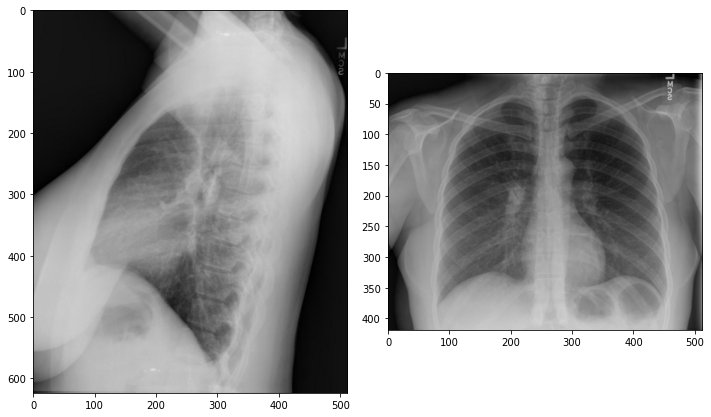

Beam Search index is : 3
Actual impression is: <start> heart size normal right hilar calcifications are suggestive prior granulomatous disease otherwise the mediastinal silhouette and pulmonary vascularity are within normal limits there no focal airspace consolidation pleural effusion pneumothora <end>
Predicted impression is : with clear infiltrate disease chest within
**************************************************
One-gram: 0.0061  || Cumulative  one gram: 0.0061
Two-gram: 0.0183  || Cumulative  two gram: 0.0106
Three-gram: 0.0183|| Cumulative  three gram: 0.0127
Four-gram: 0.0183 || Cumulative four gram: 0.0139


In [25]:
test_img_cap_beam(test_input[6], test_output[6],3 )

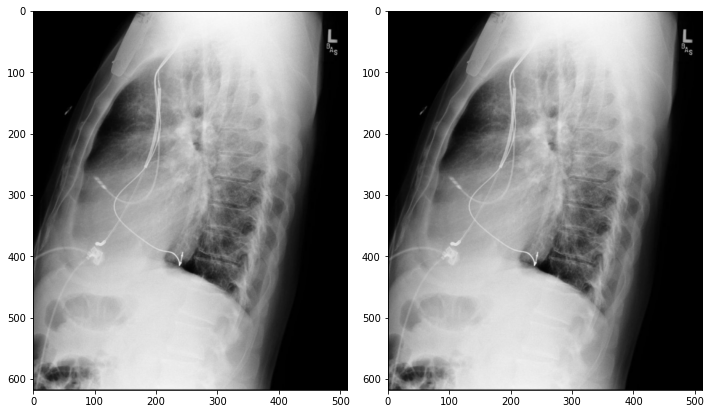

Beam Search index is : 5
Actual impression is: <start> no acute pulmonary abnormality moderate cardiomegaly without pulmonary edema <end>
Predicted impression is : with normal lungs pleural may normal lungs pleural infiltrate disease chest lung appearance chest lung disease chest lung no cardiopulmonary atelectasis limits chest lung no cardiopulmonary left stable chronic
**************************************************
One-gram: 0.0345  || Cumulative  one gram: 0.0345
Two-gram: 1.0000  || Cumulative  two gram: 0.1857
Three-gram: 1.0000|| Cumulative  three gram: 0.3292
Four-gram: 1.0000 || Cumulative four gram: 0.4309


In [26]:
test_img_cap_beam(test_input[45], test_output[45], 5)

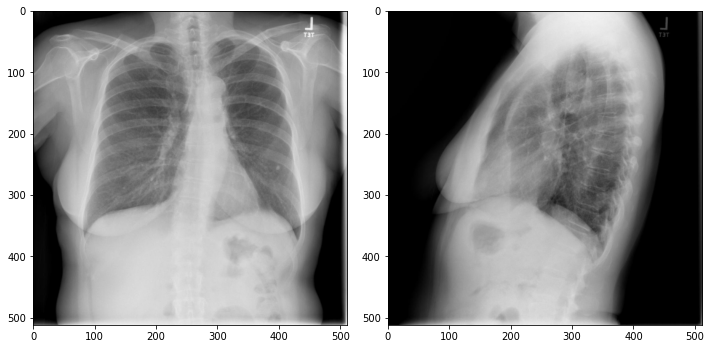

Beam Search index is : 3
Actual impression is: <start> heart size normal lungs are clear calcified granuloma the left midlung status post resection left upper lobe no adenopathy nodules masses no effusion <end>
Predicted impression is : with clear infiltrate disease chest within
**************************************************
One-gram: 0.0098  || Cumulative  one gram: 0.0098
Two-gram: 0.0588  || Cumulative  two gram: 0.0240
Three-gram: 0.0588|| Cumulative  three gram: 0.0326
Four-gram: 0.0588 || Cumulative four gram: 0.0376


In [27]:
test_img_cap_beam(test_input[98], test_output[98], 3)

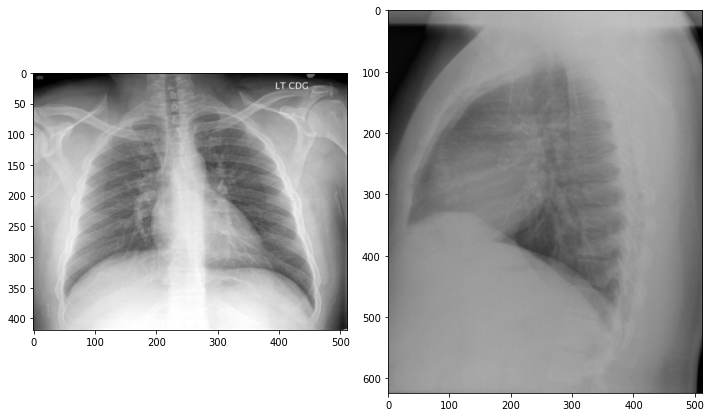

Beam Search index is : 9
Actual impression is: <start> picc catheter tip mid svc heart size normal lungs clear <end>
Predicted impression is : no cardiopulmonary left stable chronic
**************************************************
One-gram: 0.0000  || Cumulative  one gram: 0.0000
Two-gram: 0.0000  || Cumulative  two gram: 0.0000
Three-gram: 0.0000|| Cumulative  three gram: 0.0000
Four-gram: 0.0000 || Cumulative four gram: 0.0000


In [28]:
test_img_cap_beam(test_input[150], test_output[150], 9)

In [29]:
columns = ["idx", "image_1", "image_2", "actual", "predicted", "score"]
df = pd.DataFrame(columns = columns)
for i in tqdm(range(len(test_input))):
    result, text_predicted = beam_search(test_input[i])
    actual = ' '.join([str(elem) for elem in test_output[i].split()[1:-1]])
    predicted = ' '.join([str(elem) for elem in result[1:]])
    df = df.append(pd.Series([i, test_input[i][0], test_input[i][1], actual, predicted, sentence_bleu([test_output[i].split()[1:-1]], result[1:], weights=(1, 0, 0, 0))], index = columns), ignore_index = True)
df.head(20)

100%|██████████| 399/399 [35:25<00:00,  5.33s/it]


,idx,image_1,image_2,actual,predicted,score
0,0,CXR1979_IM-0637-2001.png,CXR1979_IM-0637-1001.png,there no radiographic evidence acute cardiopul...,no cardiopulmonary left stable chronic,0.268128
1,1,CXR1458_IM-0296-1001.png,CXR1458_IM-0296-2001.png,stable cardiomegaly clear lungs,with clear normal lungs pleural lung further c...,0.103448
2,2,CXR1204_IM-0138-2001.png,CXR1204_IM-0138-1001.png,no acute cardiopulmonary disease,with normal lungs pleural may normal lungs ple...,0.103448
3,3,CXR2190_IM-0800-3001.png,CXR2190_IM-0800-2001.png,clear lungs,no cardiopulmonary left stable no study airspa...,0.000000
4,4,CXR3656_IM-1817-1001.png,CXR3656_IM-1817-2001.png,negative for acute cardiopulmonary disease,with no fluid copd active no fractures chest a...,0.000000
5,5,CXR3741_IM-1869-1002001.png,CXR3741_IM-1869-1002001.png,no active disease,with no fluid copd active no fractures chest a...,0.105263
6,6,CXR603_IM-2193-2001.png,CXR603_IM-2193-1001.png,heart size normal right hilar calcifications a...,opacity findings the chest chest abdomen the m...,0.106667
7,7,CXR1870_IM-0563-1001.png,CXR1870_IM-0563-2001.png,marked cardiomegaly low lung volumes,abnormality pneumonia are without limits no in...,0.038462
8,8,CXR2694_IM-1165-1001.png,CXR2694_IM-1165-2001.png,no acute cardiopulmonary disease,opacity findings the chest chest abdomen the m...,0.026667
9,9,CXR3975_IM-2035-1001.png,CXR3975_IM-2035-2001.png,no acute cardiopulmonary findings,opacity findings right abnormality findings mo...,0.100000


**Let's make a dataframe for poor scores**

In [30]:
poor_data_frame= df[df['score']<0.08]

In [31]:
poor_data_frame.head()

,idx,image_1,image_2,actual,predicted,score
3,3,CXR2190_IM-0800-3001.png,CXR2190_IM-0800-2001.png,clear lungs,no cardiopulmonary left stable no study airspa...,0.000000
4,4,CXR3656_IM-1817-1001.png,CXR3656_IM-1817-2001.png,negative for acute cardiopulmonary disease,with no fluid copd active no fractures chest a...,0.000000
7,7,CXR1870_IM-0563-1001.png,CXR1870_IM-0563-2001.png,marked cardiomegaly low lung volumes,abnormality pneumonia are without limits no in...,0.038462
8,8,CXR2694_IM-1165-1001.png,CXR2694_IM-1165-2001.png,no acute cardiopulmonary disease,opacity findings the chest chest abdomen the m...,0.026667
11,11,CXR3660_IM-1820-1001.png,CXR3660_IM-1820-2001.png,negative for acute cardiopulmonary abnormality,abnormality pneumonia are without limits no in...,0.076923


**Let's check the duplicate images poor score as well**

In [32]:
poor_data_frame['duplicate_img']= np.where(poor_data_frame['image_1']== poor_data_frame['image_2'], 1, 0)

In [33]:
poor_data_frame.head()

,idx,image_1,image_2,actual,predicted,score,duplicate_img
3,3,CXR2190_IM-0800-3001.png,CXR2190_IM-0800-2001.png,clear lungs,no cardiopulmonary left stable no study airspa...,0.000000,0
4,4,CXR3656_IM-1817-1001.png,CXR3656_IM-1817-2001.png,negative for acute cardiopulmonary disease,with no fluid copd active no fractures chest a...,0.000000,0
7,7,CXR1870_IM-0563-1001.png,CXR1870_IM-0563-2001.png,marked cardiomegaly low lung volumes,abnormality pneumonia are without limits no in...,0.038462,0
8,8,CXR2694_IM-1165-1001.png,CXR2694_IM-1165-2001.png,no acute cardiopulmonary disease,opacity findings the chest chest abdomen the m...,0.026667,0
11,11,CXR3660_IM-1820-1001.png,CXR3660_IM-1820-2001.png,negative for acute cardiopulmonary abnormality,abnormality pneumonia are without limits no in...,0.076923,0


**Let's count the values of duplicate images which have poor score**

In [34]:
poor_data_frame['duplicate_img'].value_counts()

0    189
1     27
Name: duplicate_img, dtype: int64



*   So, there are 27 duplicate image data whose predicted score is poor as we already know that these data point we considered as noise and equally split among all the data sets.
*   Let's ignore those data points in the prediction and perform the analysis.



In [35]:
columns = ["idx", "image_1", "image_2", "actual", "predicted", "score"]
df1 = pd.DataFrame(columns = columns)
for i in tqdm(range(len(test_input))):
    if test_input[i][0] != test_input[i][1]:
        result, text_predicted = beam_search(test_input[i])
        actual = ' '.join([str(elem) for elem in test_output[i].split()[1:-1]])
        predicted = ' '.join([str(elem) for elem in result[1:]])
        df1 = df1.append(pd.Series([i, test_input[i][0], test_input[i][1], actual, predicted, sentence_bleu([test_output[i].split()[1:-1]], result[1:], weights=(1, 0, 0, 0))], index = columns), ignore_index = True)
df1.head(20)

100%|██████████| 399/399 [32:42<00:00,  4.92s/it]


,idx,image_1,image_2,actual,predicted,score
0,0,CXR1979_IM-0637-2001.png,CXR1979_IM-0637-1001.png,there no radiographic evidence acute cardiopul...,opacity findings right abnormality findings mo...,0
1,1,CXR1458_IM-0296-1001.png,CXR1458_IM-0296-2001.png,stable cardiomegaly clear lungs,with no fluid copd active no fractures chest a...,0
2,2,CXR1204_IM-0138-2001.png,CXR1204_IM-0138-1001.png,no acute cardiopulmonary disease,no cardiopulmonary left stable chronic,0.4
3,3,CXR2190_IM-0800-3001.png,CXR2190_IM-0800-2001.png,clear lungs,with clear normal lungs pleural lung further c...,0.0689655
4,4,CXR3656_IM-1817-1001.png,CXR3656_IM-1817-2001.png,negative for acute cardiopulmonary disease,opacity findings right abnormality findings mo...,0.2
5,6,CXR603_IM-2193-2001.png,CXR603_IM-2193-1001.png,heart size normal right hilar calcifications a...,no cardiopulmonary left stable no study airspa...,0.117997
6,7,CXR1870_IM-0563-1001.png,CXR1870_IM-0563-2001.png,marked cardiomegaly low lung volumes,with normal lungs pleural may normal lungs ple...,0.0344828
7,8,CXR2694_IM-1165-1001.png,CXR2694_IM-1165-2001.png,no acute cardiopulmonary disease,opacity findings right abnormality findings mo...,0
8,9,CXR3975_IM-2035-1001.png,CXR3975_IM-2035-2001.png,no acute cardiopulmonary findings,with clear normal lungs pleural lung further c...,0.103448
9,10,CXR508_IM-2125-1002.png,CXR508_IM-2125-1001.png,no acute cardiopulmonary abnormality,opacity findings right abnormality findings mo...,0.1


**Let's get the best score data points**

In [36]:
best_score_data_points= df1[df1['score']>0.3]
best_score_data_points.head()

,idx,image_1,image_2,actual,predicted,score
2,2,CXR1204_IM-0138-2001.png,CXR1204_IM-0138-1001.png,no acute cardiopulmonary disease,no cardiopulmonary left stable chronic,0.4
32,34,CXR1477_IM-0309-2001.png,CXR1477_IM-0309-1001.png,no acute cardiopulmonary findings,no cardiopulmonary left stable chronic,0.4
53,61,CXR3075_IM-1436-1001.png,CXR3075_IM-1436-2001.png,no acute cardiopulmonary findings,no cardiopulmonary left stable chronic,0.4
60,68,CXR429_IM-2070-1001.png,CXR429_IM-2070-2001.png,no acute cardiopulmonary findings,no cardiopulmonary left stable chronic,0.4
96,110,CXR1199_IM-0133-1002.png,CXR1199_IM-0133-1001.png,no radiographic evidence active cardiopulmonar...,no cardiopulmonary left stable chronic,0.327492


**Let's sort these values according to score**

In [37]:
sorted_values = df1.sort_values('score',ascending= False)
sorted_values.head()

,idx,image_1,image_2,actual,predicted,score
287,324,CXR609_IM-2197-1001.png,CXR609_IM-2197-2001.png,no acute cardiopulmonary abnormality,no cardiopulmonary left stable chronic,0.4
60,68,CXR429_IM-2070-1001.png,CXR429_IM-2070-2001.png,no acute cardiopulmonary findings,no cardiopulmonary left stable chronic,0.4
145,164,CXR532_IM-2140-1001.png,CXR532_IM-2140-2001.png,no acute cardiopulmonary abnormality,no cardiopulmonary left stable chronic,0.4
119,138,CXR3470_IM-1686-2001.png,CXR3470_IM-1686-1001.png,no acute cardiopulmonary abnormalities,no cardiopulmonary left stable chronic,0.4
32,34,CXR1477_IM-0309-2001.png,CXR1477_IM-0309-1001.png,no acute cardiopulmonary findings,no cardiopulmonary left stable chronic,0.4


**Let's get the length of sorted data frame**

In [38]:
length_sorted_data_frame= len(sorted_values[sorted_values['score']<0.08])
length_sorted_data_frame

204

In [39]:
print('{:.1f} % of the data seems having poor bleu score. let take the those data point do some analysis'.format((204/375)*100))

54.4 % of the data seems having poor bleu score. let take the those data point do some analysis


In [40]:
poor_data_frame= sorted_values[sorted_values['score']<0.08]
poor_data_frame.head()

,idx,image_1,image_2,actual,predicted,score
203,230,CXR1957_IM-0624-4004.png,CXR1957_IM-0624-0001.png,bilateral pleural effusions right larger than ...,opacity findings the chest chest abdomen the m...,0.08
158,177,CXR1961_IM-0628-3001.png,CXR1961_IM-0628-2001.png,limited eamination with stable cardiomegaly an...,opacity findings the chest chest abdomen the m...,0.08
15,16,CXR549_IM-2153-2001.png,CXR549_IM-2153-1001.png,no acute cardiopulmonary process stable appear...,opacity findings the chest chest abdomen the m...,0.08
184,211,CXR3972_IM-2032-1001.png,CXR3972_IM-2032-2001.png,continued hilar fullness consistent with adeno...,opacity findings the chest chest abdomen the m...,0.08
292,329,CXR1208_IM-0141-1001.png,CXR1208_IM-0141-2001.png,no acute cardiopulmonary finding,abnormality pneumonia are without limits no in...,0.0769231


**Lets get the word count of actual impression of the poor bleau score data frame**

In [41]:
poor_data_frame['actual_count'] = poor_data_frame['actual'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
poor_data_frame.head()

,idx,image_1,image_2,actual,predicted,score,actual_count
203,230,CXR1957_IM-0624-4004.png,CXR1957_IM-0624-0001.png,bilateral pleural effusions right larger than ...,opacity findings the chest chest abdomen the m...,0.08,23
158,177,CXR1961_IM-0628-3001.png,CXR1961_IM-0628-2001.png,limited eamination with stable cardiomegaly an...,opacity findings the chest chest abdomen the m...,0.08,14
15,16,CXR549_IM-2153-2001.png,CXR549_IM-2153-1001.png,no acute cardiopulmonary process stable appear...,opacity findings the chest chest abdomen the m...,0.08,10
184,211,CXR3972_IM-2032-1001.png,CXR3972_IM-2032-2001.png,continued hilar fullness consistent with adeno...,opacity findings the chest chest abdomen the m...,0.08,22
292,329,CXR1208_IM-0141-1001.png,CXR1208_IM-0141-2001.png,no acute cardiopulmonary finding,abnormality pneumonia are without limits no in...,0.0769231,4


In [42]:
print('The shape of the poor bleau score data frame is:',poor_data_frame.shape)

The shape of the poor bleau score data frame is: (204, 7)


Description of actual count in which we get the min and max word count.

In [43]:
poor_data_frame['actual_count'].describe() 

count    204.000000
mean       9.053922
std        9.152890
min        1.000000
25%        4.000000
50%        4.000000
75%       12.000000
max       49.000000
Name: actual_count, dtype: float64



*   minimum word count is 1 and maximum word count is 49 . we have used the max_length_of_words in our prediction as 80 but here in actua there is no word who is larger than 80. so no need to ignore any actual sentence. 



**Let's do each data point analysis**

In [44]:
import random

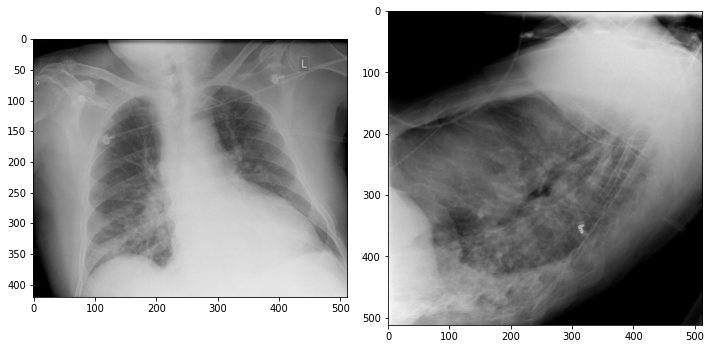

bleau-Score: 0.03448275862068965
Actual impression: cardiomegaly and small bilateral pleural effusions abnormal pulmonary opacities most suggestive pulmonary edema primary differential diagnosis includes infection and aspiration clinical correlation recommended
Predicted impression: with clear normal lungs pleural lung further chest abdomen disease density this disease lobe findings low the heart no cardiopulmonary left stable no cardiopulmonary finding no cardiopulmonary left right
count of words: 23


In [47]:
random_point=random.choice(poor_data_frame.index.tolist())
names_of_image = [poor_data_frame["image_1"][random_point], poor_data_frame["image_2"][random_point]]
fig, axs = plt.subplots(1, len(names_of_image), figsize = (10,10), tight_layout=True)
cnt = 0
for img, subplot in zip(names_of_image, axs.flatten()):
    img_=mpimg.imread(path_of_image+img)
    imgplot = axs[cnt].imshow(img_, cmap = 'bone')
    cnt +=1
plt.show()
print("bleau-Score:", poor_data_frame["score"][random_point])
print("Actual impression:", poor_data_frame["actual"][random_point])
print("Predicted impression:", poor_data_frame["predicted"][random_point])
print("count of words:", poor_data_frame["actual_count"][random_point])



*   here length of word is 23 and there is overlap in the actual impression words as well as predicted impression
*   length of the actual impression is more as compare to predicted impression. bleau score is not good because of not considering the meaning of sentences.



**Let's have another data point**

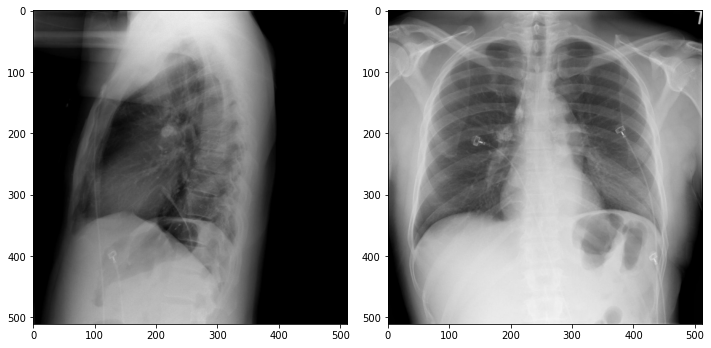

bleau-Score: 0.01509869171115925
Actual impression: heart size within normal limits stable mediastinal contours mediastinal surgical clips mediastinal and right hilar calcifications suggest previous granulomatous process improved lung volumes left base opacities most suggestive scarring no focal alveolar consolidation no definite pleural effusion seen bronchovascular crowding without typical findings pulmonary edema
Predicted impression: opacity findings right abnormality findings most and process negative for
count of words: 45


In [56]:
random_point=random.choice(poor_data_frame.index.tolist())
names_of_image = [poor_data_frame["image_1"][random_point], poor_data_frame["image_2"][random_point]]
fig, axs = plt.subplots(1, len(names_of_image), figsize = (10,10), tight_layout=True)
cnt = 0
for img, subplot in zip(names_of_image, axs.flatten()):
    img_=mpimg.imread(path_of_image+img)
    imgplot = axs[cnt].imshow(img_, cmap = 'bone')
    cnt +=1
plt.show()
print("bleau-Score:", poor_data_frame["score"][random_point])
print("Actual impression:", poor_data_frame["actual"][random_point])
print("Predicted impression:", poor_data_frame["predicted"][random_point])
print("count of words:", poor_data_frame["actual_count"][random_point])



*   Here word count is 45 , there is no erro in actual words. still cant find any image wise pattern issue.
*   predicted word is poor not give any meaning related to actual impression



**summary**



*   As i observe that the bleu score greater than 0 have the partial meaning of the actual impression which we can considered as the good prediction .

*   One important information is that when we have the sentence which have more than 20 words they have the poor bleu score it means our model not perform good for the larger sentences.






**Let's get the data points which have the score as proper 0.**

In [58]:
poor_data_frame_zero=  poor_data_frame[poor_data_frame['score']== 0]
poor_data_frame_zero.head()

,idx,image_1,image_2,actual,predicted,score,actual_count
198,225,CXR2747_IM-1198-1001.png,CXR2747_IM-1198-2001.png,small bilateral pleural effusions,with no fluid copd active no fractures chest a...,0,4
199,226,CXR2152_IM-0772-2001.png,CXR2152_IM-0772-1001.png,normal eam,with clear infiltrate disease chest within,0,2
144,163,CXR2261_IM-0852-1001.png,CXR2261_IM-0852-2001.png,no acute active cardiac pulmonary pleural disease,opacity findings right abnormality findings mo...,0,7
325,368,CXR2713_IM-1180-2001.png,CXR2713_IM-1180-1001.png,low lung volume study with minimal bibasilar a...,no cardiopulmonary pulmonary evaluation view n...,0,10
151,170,CXR959_IM-2449-2001.png,CXR959_IM-2449-1001.png,patchy right lower lobe airspace disease may d...,no cardiopulmonary left stable chronic,0,10


In [59]:
print(' The total number of data points which have the zero bleau score: ',len(poor_data_frame_zero))

 The total number of data points which have the zero bleau score:  62


**Lets get the data points whose word count of impression is short and have the zero bleu score.**

In [61]:
poor_data_frame_zero_short_sentence= poor_data_frame_zero[poor_data_frame_zero['actual_count']< 20]
poor_data_frame_zero_short_sentence.head()  

,idx,image_1,image_2,actual,predicted,score,actual_count
198,225,CXR2747_IM-1198-1001.png,CXR2747_IM-1198-2001.png,small bilateral pleural effusions,with no fluid copd active no fractures chest a...,0,4
199,226,CXR2152_IM-0772-2001.png,CXR2152_IM-0772-1001.png,normal eam,with clear infiltrate disease chest within,0,2
144,163,CXR2261_IM-0852-1001.png,CXR2261_IM-0852-2001.png,no acute active cardiac pulmonary pleural disease,opacity findings right abnormality findings mo...,0,7
325,368,CXR2713_IM-1180-2001.png,CXR2713_IM-1180-1001.png,low lung volume study with minimal bibasilar a...,no cardiopulmonary pulmonary evaluation view n...,0,10
151,170,CXR959_IM-2449-2001.png,CXR959_IM-2449-1001.png,patchy right lower lobe airspace disease may d...,no cardiopulmonary left stable chronic,0,10


In [62]:
print(' The shape of data points which have the score zero and have the word count less than 20 is: ',poor_data_frame_zero_short_sentence.shape)

 The shape of data points which have the score zero and have the word count less than 20 is:  (56, 7)


**Let's get the best 25 random patient x-ray  which have good score.**

***** Displaying best result random 16 patient X-Ray 1st image *****


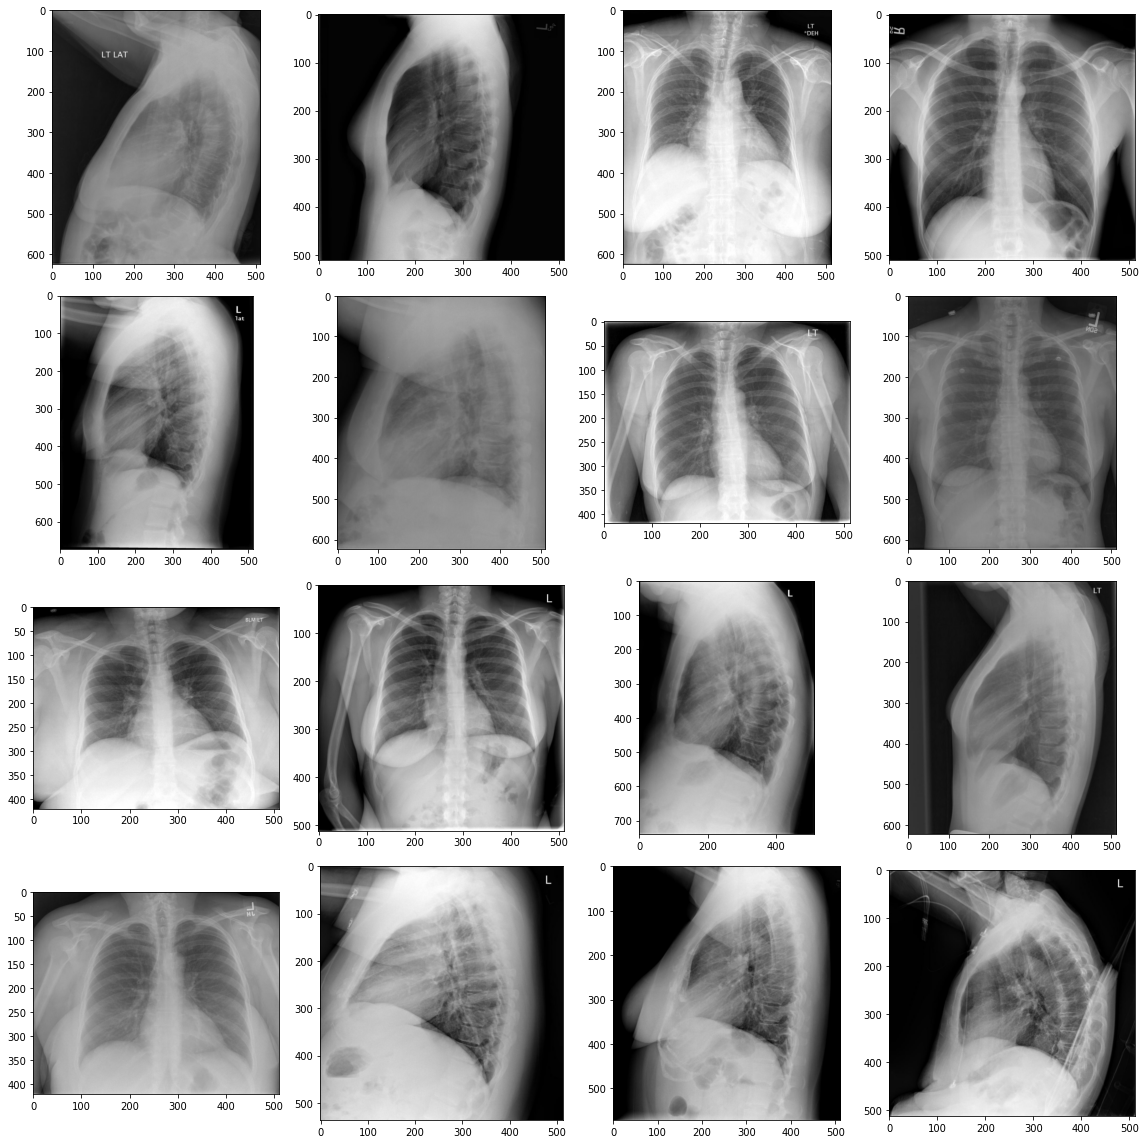

In [69]:
print("***** Displaying best result random 16 patient X-Ray 1st image *****")
figure, axis = plt.subplots(4, 4, figsize = (16,16), tight_layout=True)
for row, subplot in zip(best_score_data_points[0:16].itertuples(), axis.flatten()):
    img=mpimg.imread(path_of_image+row.image_1)
    subplot.imshow(img, cmap = 'bone')
plt.show()

**Important points in best bleu score images**



*   Here i observe that images alignments  is in proper manner
*   We are able to the brighter view of chest bones in the images.

*   Here no line and any disturbance is not present in the images.
*   Here we are able to see that dull images are visualized properly.





**Bad bleu score chest x ray images**

***** Displaying bad result random 16 patient X-Ray 1st image *****


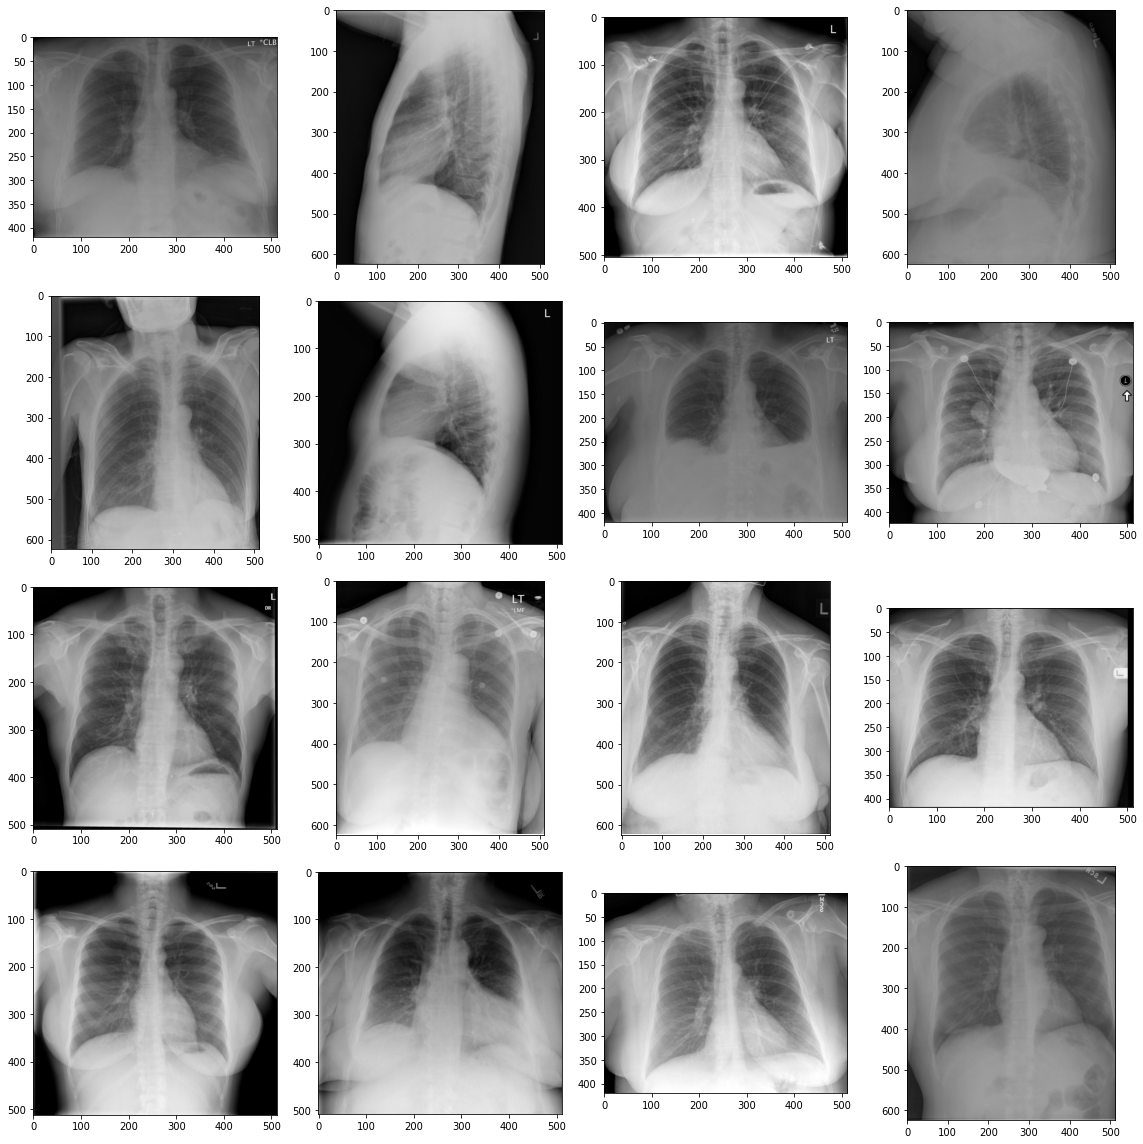

In [70]:
print("***** Displaying bad result random 16 patient X-Ray 1st image *****")
figure, axis = plt.subplots(4, 4, figsize = (16,16), tight_layout=True)
for row, subplot in zip(poor_data_frame_zero[0:16].itertuples(), axis.flatten()):
    img=mpimg.imread(path_of_image+row.image_1)
    subplot.imshow(img, cmap = 'bone')
plt.show()

**Important points in the bad bleu score images**

*   here images are very vague not able to see properly(row,column): images are (1,4),(2,3),(3,2),(4,4)
*   In many images there is too much brigtness in which we are not able to see properly.



**Let's check the data points problems in image which have poor score**

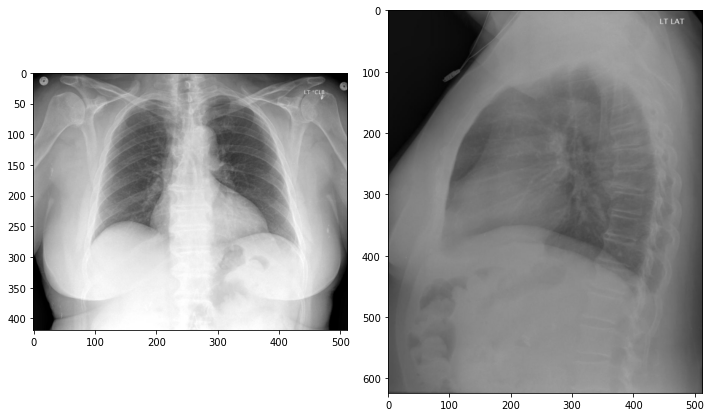

bleau-Score: 0
Actual impression: heart size normal slightly tortuous calcified aorta no pneumothora effusion no evidence aortic transection
Predicted impression: with clear infiltrate disease chest within
count of words: 14


In [71]:
random_point=random.choice(poor_data_frame_zero.index.tolist())
names_of_image = [poor_data_frame_zero["image_1"][random_point], poor_data_frame_zero["image_2"][random_point]]
fig, axs = plt.subplots(1, len(names_of_image), figsize = (10,10), tight_layout=True)
cnt = 0
for img, subplot in zip(names_of_image, axs.flatten()):
    img_=mpimg.imread(path_of_image+img)
    imgplot = axs[cnt].imshow(img_, cmap = 'bone')
    cnt +=1
plt.show()
print("bleau-Score:", poor_data_frame_zero["score"][random_point])
print("Actual impression:", poor_data_frame_zero["actual"][random_point])
print("Predicted impression:", poor_data_frame_zero["predicted"][random_point])
print("count of words:", poor_data_frame_zero["actual_count"][random_point])



*   Here we able to observe that the second picture is total vague we are not able to see the picture properly.




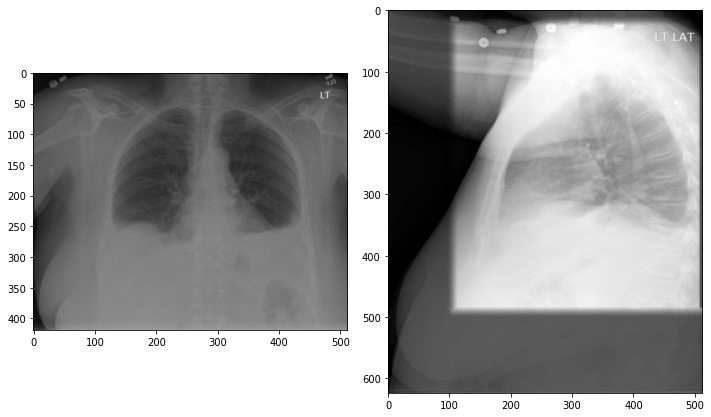

bleau-Score: 0
Actual impression: bilateral large pleural effusion possibly from pleuritis sympathetic from the known pancreatitis
Predicted impression: with clear infiltrate disease chest within
count of words: 12


In [72]:
random_point=random.choice(poor_data_frame_zero.index.tolist())
names_of_image = [poor_data_frame_zero["image_1"][random_point], poor_data_frame_zero["image_2"][random_point]]
fig, axs = plt.subplots(1, len(names_of_image), figsize = (10,10), tight_layout=True)
cnt = 0
for img, subplot in zip(names_of_image, axs.flatten()):
    img_=mpimg.imread(path_of_image+img)
    imgplot = axs[cnt].imshow(img_, cmap = 'bone')
    cnt +=1
plt.show()
print("bleau-Score:", poor_data_frame_zero["score"][random_point])
print("Actual impression:", poor_data_frame_zero["actual"][random_point])
print("Predicted impression:", poor_data_frame_zero["predicted"][random_point])
print("count of words:", poor_data_frame_zero["actual_count"][random_point])



*   First images is totally been out of brightness. poor visibility in first image 
*   Second image is too bright which makes us incompetent to visualize the part of the chest.



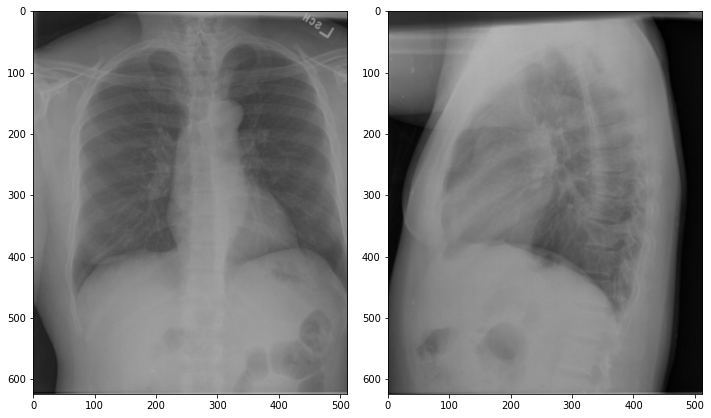

bleau-Score: 0
Actual impression: no acute cardiopulmonary finding
Predicted impression: with clear infiltrate disease chest within
count of words: 4


In [147]:
random_point=random.choice(poor_data_frame_zero.index.tolist())
names_of_image = [poor_data_frame_zero["image_1"][random_point], poor_data_frame_zero["image_2"][random_point]]
fig, axs = plt.subplots(1, len(names_of_image), figsize = (10,10), tight_layout=True)
cnt = 0
for img, subplot in zip(names_of_image, axs.flatten()):
    img_=mpimg.imread(path_of_image+img)
    imgplot = axs[cnt].imshow(img_, cmap = 'bone')
    cnt +=1
plt.show()
print("bleau-Score:", poor_data_frame_zero["score"][random_point])
print("Actual impression:", poor_data_frame_zero["actual"][random_point])
print("Predicted impression:", poor_data_frame_zero["predicted"][random_point])
print("count of words:", poor_data_frame_zero["actual_count"][random_point])



*   poor image quality in both the images. image is totally vague.



**Conclusion:**

*   As we have the knowledge from this analysis, we came to know that quality of image plays an important role . Mostly the error data points are with poor images quality.
*  The model works fine for the clear and well bright images in which every part of chest is clearly seen to us.


*   There are some images which have the high brightness there also model able to fails in the decision making so the score is not good in such type of images.
*   Most important is that model is not performing well when we have the actual word count more than 20.
* there are some error points which we can find out and then ignore those points for better results.





